<a href="https://colab.research.google.com/github/lior9005/deep-learning/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADL final project


---


**Authors:**
> Lior Sharony 316380138


> Noam Zigler 314868019


> Eden Miran 208742429


In [13]:
# Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split, Subset, Dataset, SubsetRandomSampler
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import seaborn as sns

# Eval mode
eval_mode = False
ood_as_fashion = True #define the ood
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 5.2. Data & Preprocessing

In [7]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

In [27]:
# Transformers
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

ood_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.5,), (0.5,))
])

# Mnist dataset
mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)

torch.manual_seed(0)
np.random.seed(0)

train_size = len(mnist_train_set)
mnist_val_size = int(train_size * 0.2)
mnist_train_size = train_size - mnist_val_size
mnist_train_dataset, mnist_val_dataset = random_split(mnist_train_set, [mnist_train_size, mnist_val_size])

train_idx = np.arange(len(mnist_train_dataset))
train_subset_idx = np.random.choice(train_idx, 5000)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)

mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=512, sampler=train_subset_sampler)
mnist_val_loader = DataLoader(mnist_val_dataset, batch_size=512, shuffle=False)
mnist_test_loader = DataLoader(mnist_test_set, batch_size=1000, shuffle=False)

# Ood
if(ood_as_fashion):
  ood = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)
else:
  ood = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=ood_transform)

# Generating the combined dataset
ood_indices = np.random.choice(len(ood), N, replace=False)
ood_subset = Subset(ood, ood_indices)
mnist_test_subset_idx = np.random.choice(len(mnist_test_set), N, replace=False)
mnist_test_subset = Subset(mnist_test_set, mnist_test_subset_idx)

combined_ds = CombinedDataset(mnist_test_subset, ood_subset)
combined_ds_loader = DataLoader(combined_ds, batch_size=1024, shuffle=True)

#5.3. Models

In [10]:
# Baseline model class
class Baseline_model(nn.Module):
  def __init__(self):
        super(Baseline_model, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
          )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.clf = nn.Sequential(
            nn.Linear(self._get_conv_output(), 10),
            nn.LogSoftmax(dim=1)
        )

  def _get_conv_output(self, shape = (1,28,28)):
    #Computes the size of the flattened features after the convolutional layers.
      with torch.no_grad():
          batch_size = 1
          input = torch.rand(batch_size, *shape)
          output_feat = self.encoder(input)
          n_size = output_feat.view(batch_size, -1).shape[1]
      return n_size

  def forward(self,x):
      encoded_vector = self.encoder(x)
      encoded_vector_clf = encoded_vector.view(encoded_vector.size(0), -1)
      pred = self.clf(encoded_vector_clf)
      recon = self.decoder(encoded_vector)
      return pred, recon

'''
# OSR model class
class OSR_model(nn.Baseline_model):
  def __init__(self):
        super(OSR_model, self).__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
  def forward(self,x):
      encoded_vector = self.encoder(x)
      encoded_vector_clf = encoded_vector.view(encoded_vector.size(0), -1)
      pred = self.clf(encoded_vector_clf)
      recon = self.decoder(encoded_vector)
      return pred
'''


'\n# OSR model class\nclass OSR_model(nn.Baseline_model):\n  def __init__(self):\n        super(OSR_model, self).__init__()\n\n        self.decoder = nn.Sequential(\n            nn.ConvTranspose2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n            nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size=3, stride=1, padding=1),\n            nn.ReLU(),\n        )\n  def forward(self,x):\n      encoded_vector = self.encoder(x)\n      encoded_vector_clf = encoded_vector.view(encoded_vector.size(0), -1)\n      pred = self.clf(encoded_vector_clf)\n      recon = self.decoder(encoded_vector)\n      return pred\n'

#5.4. Training

Training MNIST MLP:   0%|          | 0/50 [00:00<?, ?it/s]

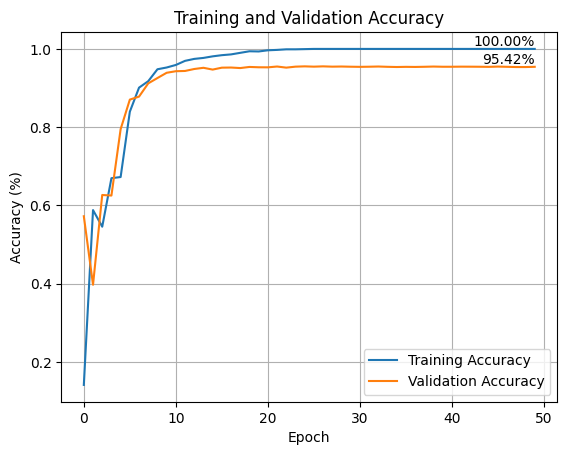

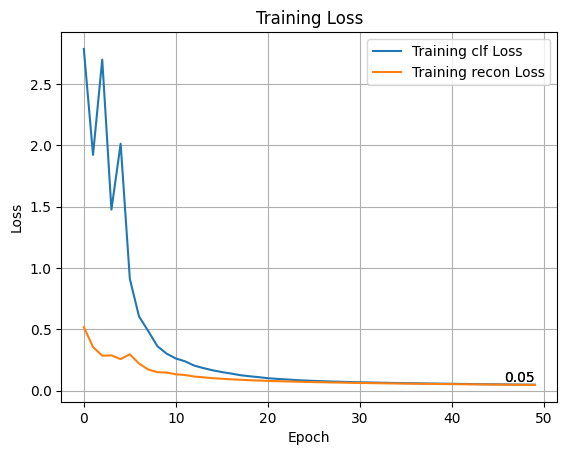

In [11]:
if not (eval_mode):

  def train_baseline_model(model, train_loader, val_loader, clf_criterion, recon_criterion, optimizer, num_epochs):
    # Dictionary to store training and validation statistics
    results_dict = {
        'train_clf_loss': [],
        'val_clf_loss': [],
        'train_recon_loss': [],
        'val_recon_loss': [],
        'val_acc': [],
        'train_acc': []
    }

    # Loop over each epoch
    for epoch in tqdm(range(num_epochs), desc="Training MNIST MLP"):
        for phase in ['train', 'val']:  # Training phase and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()  # Set model to evaluation mode
                dataloader = val_loader

            # Initialize statistics for loss and accuracy
            running_loss = 0.0
            running_corrects = 0
            total_samples = 0
            running_recon_loss = 0.0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass (with gradient tracking during training)
                with torch.set_grad_enabled(phase == 'train'):
                    # Get outputs and reconstructions from the model
                    outputs, recon = model(inputs)

                    # Classifier loss (CrossEntropyLoss)
                    clf_loss = clf_criterion(outputs, labels)

                    # Reconstruction loss (Mean Squared Error)
                    recon_loss = recon_criterion(recon, inputs)

                    # Total loss is the sum of classifier and reconstruction loss
                    total_loss = clf_loss + recon_loss

                    if phase == 'train':
                        # Backpropagation and optimizer step during training
                        total_loss.backward()
                        optimizer.step()

                # Update statistics for both loss and accuracy
                running_loss += total_loss.item() * inputs.size(0)
                running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)
                running_recon_loss += recon_loss.item() * inputs.size(0)
                total_samples += labels.size(0)

            # Calculate average loss and accuracy for the epoch
            epoch_clf_loss = running_loss / total_samples
            epoch_clf_acc = running_corrects.double() / total_samples
            epoch_recon_loss = running_recon_loss / total_samples

            # Store results
            results_dict[f'{phase}_clf_loss'].append(epoch_clf_loss)
            results_dict[f'{phase}_acc'].append(epoch_clf_acc.item())
            results_dict[f'{phase}_recon_loss'].append(epoch_recon_loss)
    return results_dict

  # OSR model training function



  def plot_training_results(result_dict):
    plt.plot(result_dict['train_acc'], label='Training Accuracy')
    plt.plot(result_dict['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    final_train_acc = result_dict['train_acc'][-1]
    final_val_acc = result_dict['val_acc'][-1]
    offset = 0.5
    plt.text(len(result_dict['train_acc']) - 1, final_train_acc, f'{final_train_acc*100:.2f}%', ha='right', va='bottom')
    plt.text(len(result_dict['val_acc']) - 1, final_val_acc, f'{final_val_acc*100:.2f}%', ha='right', va='bottom')
    plt.show()

    plt.plot(result_dict['train_clf_loss'], label='Training clf Loss')
    plt.plot(result_dict['train_recon_loss'], label='Training recon Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True)
    final_clf_train_loss =result_dict['train_clf_loss'][-1]
    final_recon_train_loss = result_dict['train_recon_loss'][-1]
    plt.text(len(result_dict['train_clf_loss']) - 1, final_clf_train_loss, f'{final_clf_train_loss:.2f}', ha='right', va='bottom')
    plt.text(len(result_dict['train_recon_loss']) - 1, final_recon_train_loss, f'{final_recon_train_loss:.2f}', ha='right', va='bottom')
    plt.show()

  # Training and validation loss and accuracy for MNIST plot - baseline model
  baseline_num_epoch = 50
  baseline_model = Baseline_model().to(device)
  lr = 0.1
  clf_criterion = nn.NLLLoss()
  recon_criterion = nn.MSELoss()
  optimizer = optim.SGD(baseline_model.parameters(), lr=lr, momentum=0.9)

  result_dict = train_baseline_model(baseline_model,mnist_train_loader, mnist_val_loader, clf_criterion, recon_criterion, optimizer, baseline_num_epoch)
  plot_training_results(result_dict)

    # Training and validation loss and accuracy for MNIST plot - osr model




# save the weights
  torch.save(baseline_model.state_dict(), './baseline model.pth')


#5.5 Evaluation - CIFAR10/Fashion-MNIST

**Baseline results:**

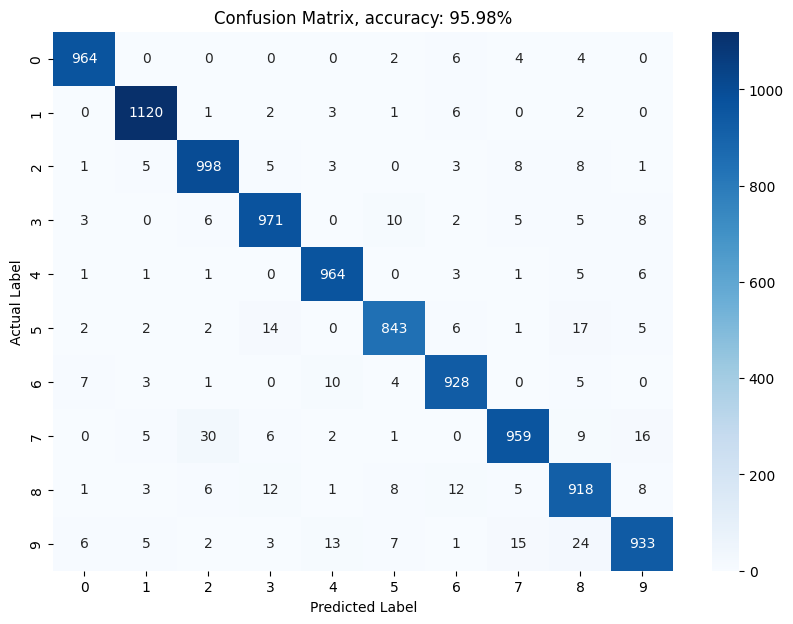

In [25]:
if (eval_mode):
    # Load the trained models weights
    baseline_model = Baseline_model()
    baseline_model.load_state_dict(torch.load('./baseline model.pth'))
    baseline_model.to(device)
    baseline_model.eval()

def eval_baseline(model, testloader):
    correct = 0
    total = 0
    all_predicted = []
    all_labels = []
    with torch.no_grad():
        for images, labels in testloader:
            labels = labels.to(device)
            images = images.to(device)
            outputs, _  = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulate predictions and labels for confusion matrix
            all_predicted.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predicted)

    return accuracy, cm

# Baseline results
accuracy, cm = eval_baseline(baseline_model, mnist_test_loader)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.title(f"Confusion Matrix, accuracy: {accuracy:.2f}%")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

**5.5.3. OSR approach:**

TO FILL
❌-❌❌❌❌❌❌❌❌❌--



Binary classification accuracy: 50.00%


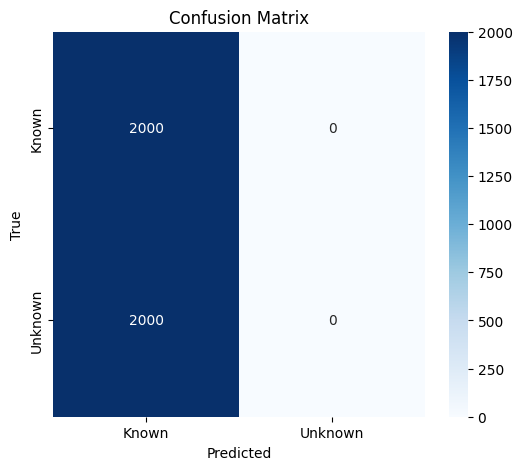

In [28]:
# OOD results

def map_to_binary_class(predictions, true_labels, known_class=0, unknown_class=1):
    # Map MNIST labels to known (0) and OOD labels to unknown (1)
    true_labels_mapped = torch.where(true_labels < 10, known_class, unknown_class)  # MNIST labels are < 10
    predictions_mapped = torch.where(predictions < 10, known_class, unknown_class)  # Same for predicted values
    return true_labels_mapped, predictions_mapped

# Collect true labels and predictions
all_true_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in combined_ds_loader:
        images, labels = images.to(device), labels.to(device)
        # Get model predictions
        outputs, _ = baseline_model(images)
        _, predicted = torch.max(outputs, 1)

        # Map labels and predictions to binary classes
        true_labels_mapped, predictions_mapped = map_to_binary_class(predicted, labels)

        all_true_labels.extend(true_labels_mapped.cpu().numpy())
        all_predictions.extend(predictions_mapped.cpu().numpy())

# Calculate binary classification accuracy
accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Binary classification accuracy: {accuracy * 100:.2f}%")

# Generate confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Known', 'Unknown'], yticklabels=['Known', 'Unknown'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# OSR results

def eval_model(model, data_loader, device):
    """ Evaluation function for the OSR task.
    Given your OSR predictions, comptues the accuracy on MNIST, OOD set and both.
    Note - this function does NOT computes the MNIST baseline accruacy.
    Returns:
     - acc_mnist
     - acc_ood
     - acc_total
    """

    # Ensure model is in evaluation mode
    model.eval()

    correct_mnist = 0
    total_mnist = 0
    correct_ood = 0
    total_ood = 0

    # No need to track gradients for evaluation, saves memory and computations
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            ### Modify output if needed ###
            data = data.view(-1, 28*28)
            # Model outputs
            outputs = model(data)


            # y pred should be a vector of size (N_batch,) -> [5, 2, ..., 10]
            # and not one-hot. You can handle this either in your model or here.

            # Assuming the model returns an (N_batch, 11) size output
            probas, y_pred = torch.max(outputs, 1)

            # Split MNIST and OOD predictions and labels
            # Assuming numerical labels, which is MNIST/CIFAR datasets default
            # Note: Not one-hot!
            mask_mnist = labels < 10
            mask_ood = ~mask_mnist
            labels_mnist = labels[mask_mnist]
            labels_ood = labels[mask_ood]

            pred_mnist = y_pred[mask_mnist]
            pred_ood = y_pred[mask_ood]

            total_mnist += labels_mnist.size(0)
            total_ood += labels_ood.size(0)
            correct_mnist += (pred_mnist == labels_mnist).sum().item()
            correct_ood += (pred_ood == labels_ood).sum().item()

    acc_mnist = correct_mnist / total_mnist
    acc_ood = correct_ood / total_ood
    acc_total = (correct_mnist + correct_ood) / (total_mnist + total_ood)

    return acc_mnist, acc_ood, acc_total


# t-SNE and/or PCA visualization (optional)


# Additional figures (optional)

# Evaluation - Unknown Dataset

In [ ]:
# placeholder for the combined OSR dataset and dataloader


# Load the trained models weights


# OOD results


# OSR results